In [1]:
import pickle
import numpy as np
from tqdm.notebook import trange, tqdm
import json
from sklearn.metrics import roc_curve, auc
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [43]:
class AV_Model(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.fc_1 = nn.Sequential(
            nn.Linear(input_sz, hidden_sz),
            nn.Dropout(p=0.5)
        )
        self.bn = nn.BatchNorm1d(hidden_sz)
        self.fc_2 = nn.Sequential(
            nn.Linear(hidden_sz, 1),
            nn.Dropout(p=0.5)
        )
    
    def forward_once(self, x):
        x = F.relu(self.fc_1(x))
        return x
    
    def forward(self, x1, x2):
        x1 = self.forward_once(x1)
        x2 = self.forward_once(x2)
        x = nn.bn(torch.abs(x1 - x2))
        x = torch.sigmoid(self.fc_2(x))
        
        return x

In [4]:
class RedditDataset(torch.utils.data.Dataset):
    def __init__(self, x_path, y, x_shape, x_idxs):
        self.XX = np.memmap(x_path, dtype='float32', mode='r', shape=x_shape)
        self.Y = y.astype('float32')
        self.x_idxs = x_idxs


    def __getitem__(self, index):
        x_1 = np.array(self.XX[self.x_idxs[index, 0]])
#         x_1 = torch.Tensor(x_1)
        x_2 = np.array(self.XX[self.x_idxs[index, 1]])
#         x_2 = torch.Tensor(x_2)
#         print(x_1.shape)
        return x_1, x_2, np.array(self.Y[index])

    def __len__(self):
        return len(self.Y)

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
COMPUTED_DATA_PATH = 'temp_data/reddit/preprocessed/'
TEMP_DATA_PATH = 'temp_data/reddit/unchunked/'

In [7]:
with open(TEMP_DATA_PATH + 'experiment_data.p', 'rb') as f:
    (   author_to_doc_idx, 
        author_to_doc_idx_test, 
        author_subreddit, 
        author_subreddit_test, 
        x_shape, 
        x_shape_test,
        X_idxs_train,
        Y_train,
        X_idxs_test,
        Y_test
    ) = pickle.load(f)
_, feature_sz = x_shape

In [44]:
model = AV_Model(feature_sz, 300)

In [28]:
train = RedditDataset(TEMP_DATA_PATH + 'XX_train.npy', Y_train, x_shape, X_idxs_train)
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=False)

test = RedditDataset(TEMP_DATA_PATH + 'XX_test.npy', Y_test, x_shape_test, X_idxs_test)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

In [45]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#initialize empty list to track batch losses
train_losses = []
validation_losses = []
model.to(device)
#train the neural network for 5 epochs
for epoch in range(10):
    model.train()
    train_loss = 0.0
    for x1, x2, y in tqdm(train_loader):
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        y = y.reshape(-1, 1)
        optimizer.zero_grad()
        
        out = model(x1, x2)
        loss = criterion(out, y)
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    
    preds = []
    labels = []
    for x1, x2, y in test_loader:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        y = y.reshape(-1, 1)
        out = model(x1, x2)
        loss = criterion(out, y)
        valid_loss += loss.item()
        
        out = out.reshape(-1).tolist()
        y = y.reshape(-1).tolist()
        preds.extend(out)
        labels.extend(y)
    fpr, tpr, thresh = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)
    train_losses.append(train_loss / len(train_loader))
    validation_losses.append(valid_loss / len(test_loader))
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(test_loader)} \t\t AUC: {roc_auc}')

RuntimeError: CUDA error: device-side assert triggered

In [15]:
validation_losses = [0.5016975207071678, 0.4594041334898198, 0.4276403086859973, 0.4116094300226003, 0.38976083925458227, 0.3832954672955665, 0.3755815276662175, 0.3663743065685785, 0.3679249838453715, 0.36355429912815573, 0.3494337900888686, 0.3570404621649857, 0.3595096759852909, 0.34673050321450755, 0.3444736761664476, 0.3408045878096455, 0.3356136129099448, 0.33719548530855764, 0.3449503838055942, 0.34479833949430316, 0.3423373078723915, 0.34732196033418344, 0.33749902505083246, 0.33771650296967237, 0.34095435977733435, 0.3301157672949532, 0.35156780969695883, 0.33390229374838143, 0.35110805181562066, 0.3435758431168163 ]

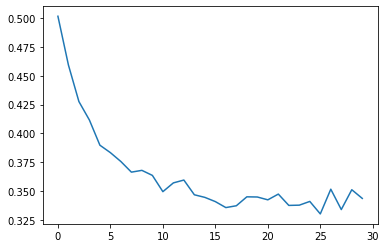

In [18]:
plt.plot(validation_losses)

In [19]:
model.eval()
preds = []
labels = []
for x1, x2, y in test_loader:
    x1, x2, y = x1.to(device), x2.to(device), y.to(device)
    out = model(x1, x2).reshape(-1).tolist()
    y = y.reshape(-1).tolist()
    preds.extend(out)
    labels.extend(y)

In [20]:
fpr, tpr, thresh = roc_curve(labels, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9673560483436726


In [21]:
torch.save(model, TEMP_DATA_PATH + 'pytorch_model.pt')